In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

def plot_bbox(image, bbox, cap, p1=None, p2=None, mask=None, alpha=0.4):
    if isinstance(image, str):
        image = Image.open(image)
    plt.figure()  # This creates a new figure every time
    ax = plt.gca()
    ax.imshow(image)

    # Draw bounding box
    if isinstance(bbox[0],list):
        for _ in bbox:
            box_plot = Rectangle((_[0], _[1]), _[2], _[3],
                                 fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(box_plot)
    else:
        box_plot = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(box_plot)

    # Draw points if provided
    if p1:
        plt.scatter(p1[0], p1[1], color='blue', s=50)
    if p2:
        plt.scatter(p2[0], p2[1], color='red', s=50)

    plt.title(cap)
    plt.axis('off')  # Optional: clean display
    plt.tight_layout()
    plt.show()

In [6]:
import json
import tempfile
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import contextlib

def xyxy_to_xywh(box):
    x_min, y_min, x_max, y_max = box
    w = float(x_max - x_min)
    h = float(y_max - y_min)
    return [float(x_min), float(y_min), w, h]

def build_coco_gt(gt_bboxes, image_id, width, height, filename, category_id, category_name):
    coco_gt = {
        "images": [
            {"id": image_id, "width": width, "height": height, "file_name": filename}
        ],
        "annotations": [],
        "categories": [
            {"id": category_id, "name": category_name}
        ],
        "info" : {
                "description": "water_meter_fsod",
                "version": "1.0",
                "year": 2025,
                "contributor": "manu",
                "date_created": "2025-09-05"
            },
    }

    # Add GT annotations
    for ann_id, box in enumerate(gt_bboxes, start=1):
        xywh = xyxy_to_xywh(box)
        ann = {
            "id": ann_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": xywh,
            "area": xywh[2] * xywh[3],
            "iscrowd": 0 ### I don't think we'll need this; each bbox is a unique object, not a crowd of objects
        }
        coco_gt["annotations"].append(ann)
    return coco_gt

def build_coco_dets(pred_bboxes, confidence, image_id, category_id):
    coco_dets = []
    for i, (box, score) in enumerate(zip(pred_bboxes, confidence), start=1):
        xywh = xyxy_to_xywh(box)
        det = {
            "image_id": image_id,
            "category_id": category_id,
            "bbox": xywh, #pred
            "score": float(score)
        }
        coco_dets.append(det)
    return coco_dets

@contextlib.contextmanager
def temp_json_file(data):
    with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False) as f:
        json.dump(data, f)
        temp_path = f.name
    try:
        yield temp_path
    finally:
        os.unlink(temp_path)

def compute_AP(cocoGt, cocoDt, image_id):
    with open(os.devnull, "w") as devnull:
        with contextlib.redirect_stdout(devnull):
            cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
            cocoEval.params.imgIds = [image_id]        # evaluate only our single image
            cocoEval.evaluate()
            cocoEval.accumulate()            
            cocoEval.summarize()
    return cocoEval.stats[:6]

def mAP(gt_bboxes, pred_bboxes, metadata):
    width, height = metadata['size']
    category_name = metadata['prompt']
    category_id = 1
    image_id = 1
    gt_bboxes = np.array(gt_bboxes)
    pred_bboxes = np.array(pred_bboxes)
    confidence = np.ones(pred_bboxes.shape[0])
    #create coco GT and PRED objects
    coco_gt = build_coco_gt(gt_bboxes, image_id, width, height, filename, category_id, category_name)
    coco_dets = build_coco_dets(pred_bboxes, confidence, image_id, category_id)
    with open(os.devnull, "w") as devnull:
        with contextlib.redirect_stdout(devnull):
            with temp_json_file(coco_gt) as gt_path, temp_json_file(coco_dets) as det_path:
                cocoGt = COCO(gt_path)
                cocoDt = cocoGt.loadRes(det_path)
    
    AP_avg, AP_50, AP_75, AP_small, AP_medium, AP_large = compute_AP(cocoGt, cocoDt, image_id)
    # print("AP (0.50:0.95) = {:.4f}".format(AP_avg))
    print("AP @ IoU=0.50 = {:.4f}".format(AP_50))
    # print("AP @ IoU=0.75 = {:.4f}".format(AP_75))
    # print(f"AP (small) = {AP_small}")
    # print(f"AP (medium) = {AP_medium}")
    # print(f"AP (large) = {AP_large}")


loading Roboflow workspace...
loading Roboflow project...
AP @ IoU=0.50 = 0.8342


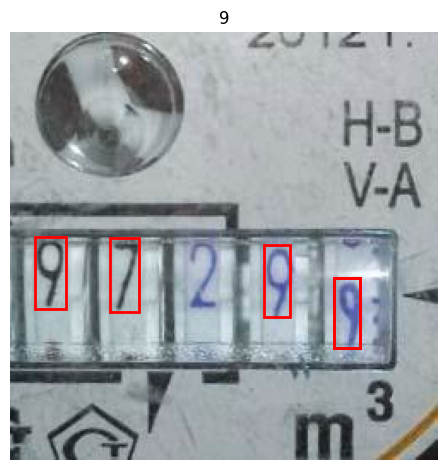

AP @ IoU=0.50 = 1.0000


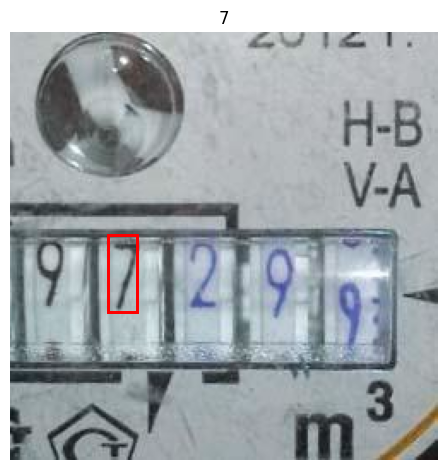

AP @ IoU=0.50 = 1.0000


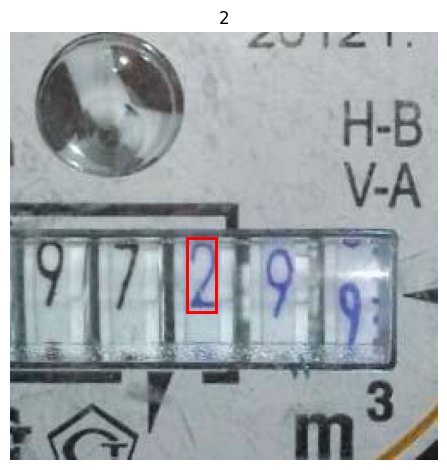

In [7]:
from PIL import Image
from train import download_dataset, RoboflowDataset

ds = download_dataset("4BDHggHM6vkVOoK3g0s3", "objectdetvlm", "water-meter-jbktv-7vz5k-fsod-ftoz-qii9s", 1)
datasets = {
    "train": RoboflowDataset(ds.location,"train"),
    "valid": RoboflowDataset(ds.location,"valid"),
    "test": RoboflowDataset(ds.location,"test"),
}
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-06-21",
    trust_remote_code=True,
    device_map={"": "cuda"}
)

def denorm_pixel(box, width, height):
    x_min = min(int(box['x_min'] * width), width - 1)
    x_max = min(int(box['x_max'] * width), width - 1)
    y_min = min(int(box['y_min'] * height), height - 1)
    y_max = min(int(box['y_max'] * height), height - 1)

    x_min = max(0, x_min); y_min = max(0, y_min)
    if x_max < x_min: x_max = x_min
    if y_max < y_min: y_max = y_min
    return {'x_min_px': x_min, 'y_min_px': y_min,
            'x_max_px': x_max, 'y_max_px': y_max}


ds = datasets["test"]
for image_idx in range(len(ds)):
    filename, image, ann = ds.__getitem__(image_idx)
    w,h = image.size
    for class_id, bbox_list in ann.items():
        #forward
        out = model.detect(image, "The digit " + str(class_id))
        preds = [list(denorm_pixel(pred, w, h).values()) for pred in out['objects']]
        #mAP
        metadata = {
            "size" : (w,h),
            "prompt": str(class_id)
        }
        mAP(ann[class_id], preds, metadata)
        #visualize
        coco_bbox_list = [xyxy_to_xywh(pred) for pred in preds]
        plot_bbox(image, coco_bbox_list, class_id)
    break
